In [11]:
# Get the output of Q/K for 4k and 64K before rope and after rope
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb
from types import MethodType
import json


model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

with open("/home/azzhang/streaming-llm/output/wikitext2_prompts_llama3.json", "r", encoding="utf-8") as f:
    prompts = json.load(f)

target_length_4k = "1k"

prompt_4k = prompts[target_length_4k]
inputs_4k = tokenizer(prompt_4k, return_tensors="pt").to(model.device)
seq_len_4 = inputs_4k["input_ids"].shape[1]

cache_4k = {}
rope_para = {}
target_layers = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

def make_patched_forward(layer_idx):
    def patched_forward(self, hidden_states, position_embeddings=None, *args, **kwargs):
        q = self.q_proj(hidden_states)
        k = self.k_proj(hidden_states)
        v = self.v_proj(hidden_states)

        bsz, seqlen, dim = q.shape
        head_dim = self.head_dim
        num_heads_q = self.config.num_attention_heads
        num_heads_kv = self.config.num_key_value_heads

        q = q.view(bsz, seqlen, num_heads_q, head_dim).transpose(1, 2)
        k = k.view(bsz, seqlen, num_heads_kv, head_dim).transpose(1, 2)

        cos, sin = position_embeddings

        rope_para[layer_idx] = {
            "cos": cos.detach().cpu(),
            "sin": sin.detach().cpu(),
            }

        q_rope, k_rope = apply_rotary_pos_emb(q, k, cos, sin)

        
        cache_4k[layer_idx] = {
                # "q_raw": q.detach().cpu(),
                "k_raw": k.detach().cpu(),
                # "q_rope": q_rope.detach().cpu(),
                # "k_rope": k_rope.detach().cpu(),
            }

        return self._orig_forward(hidden_states, position_embeddings, *args, **kwargs)
    
    return patched_forward

for layer_idx in target_layers:
    attn_layer = model.model.layers[layer_idx].self_attn
    attn_layer._orig_forward = attn_layer.forward  
    attn_layer.forward = MethodType(make_patched_forward(layer_idx), attn_layer)


with torch.no_grad():
    outputs = model(**inputs_4k)


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


In [ ]:
def compute_token_dispersion(
    K_head: torch.Tensor,
    method: str = "trace"
) -> torch.Tensor:
    
    if K_head.ndim != 2:
        raise ValueError("K_head must be a 2D tensor of shape [seq_len, head_dim]")

    K_centered = K_head - K_head.mean(dim=0, keepdim=True)  # [seq_len, head_dim]
    if method == "trace":  
        cov = K_centered.T @ K_centered / K_centered.shape[0]  # [head_dim, head_dim]
        dispersion = torch.trace(cov) / K_centered.shape[0]
        K_head.var(dim=0) # try
    elif method == "norm_var":    
        token_norms = K_centered.norm(dim=1)  # [seq_len]
        dispersion = token_norms.var(unbiased=False)

    else:
        raise ValueError(f"Unsupported method: {method}. Use 'trace' or 'norm_var'.")

    return dispersion


In [13]:
def rotate_half(x):
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat([-x2, x1], dim=-1)

def apply_rope_single_head(k, cos, sin):
    """
    k: [seq_len, head_dim]
    cos/sin: [seq_len, head_dim]  
    return: RoPE_ed K
    """
    return (k * cos) + (rotate_half(k) * sin)

def apply_reverse_rope_single_head(x_rope, cos, sin):
    """
    Reverse the RoPE operation.
    x_rope: [seq_len, head_dim]   
    cos, sin: [seq_len, head_dim] # original cos/sin
    return: x ∈ [seq_len, head_dim]  # vector before RoPE
    """
    return (x_rope * cos) - (rotate_half(x_rope) * sin)

In [14]:
# difference 
diff_before_rope_all_layer = []
diff_after_rope_all_layer = []
for layer_idx in target_layers:
    
    K_before_rope = cache_4k[layer_idx]["k_raw"].squeeze(0) # [num_head, sen_len, head_dim]
    cos = rope_para[layer_idx]["cos"].squeeze(0) # [seq_len, head_dim]
    sin = rope_para[layer_idx]["sin"].squeeze(0)
    # K_reserve_rope = apply_reverse_rope_single_head(K_before_rope, cos, sin).float()

    layer_difference_before_rope = []
    layer_difference_after_rope = []

    for target_head in range(8):
        dif_before_rope = compute_token_dispersion(K_before_rope[target_head].float())
        layer_difference_before_rope.append(dif_before_rope)

        K_reserve_rope = apply_reverse_rope_single_head(K_before_rope[target_head], cos, sin).float()
        
        dif_after_rope = compute_token_dispersion(K_reserve_rope.float())
        layer_difference_after_rope.append(dif_after_rope)

    diff_before_rope_all_layer.append(sum(layer_difference_before_rope)/len(layer_difference_before_rope))
    diff_after_rope_all_layer.append(sum(layer_difference_after_rope)/len(layer_difference_after_rope))
# print(len(diff_before_rope_all_layer))

In [ ]:
print(sum(diff_before_rope_all_layer)/len(diff_before_rope_all_layer))
print(sum(diff_after_rope_all_layer)/len(diff_after_rope_all_layer))
# before rope 1k: 159.3434 2k: 161.3083 4k: 165.2157 8k: 168.2895 16k: 157.7077 32k: 139.5949 64k: 101.9491
# after rope 1k: 270.3109 2k: 297.0381 4k: 340.3704 8k: 385.6309 16k: 513.4606 32k: 623.1927 64k: 655.7042

tensor(159.3434)
tensor(270.3109)


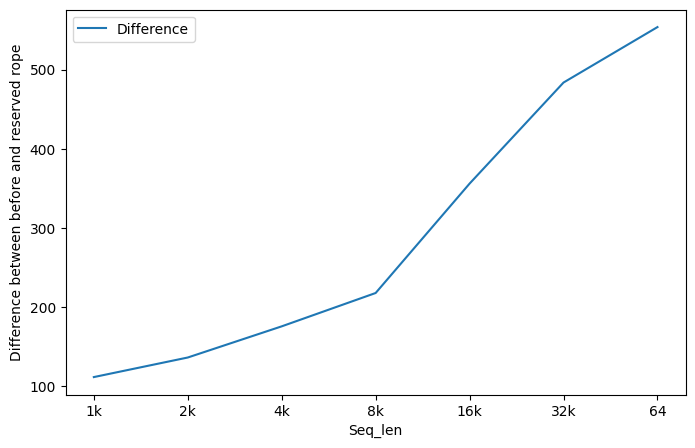

In [25]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 5))
x = [1,2,3,4,5,6,7]
difference = [(270.3109-159.3434), (297.0381-161.3083), (340.3704-165.2157), (385.6309-168.2895),
              (513.4606-157.7077), (623.1927-139.5949), (655.7042-101.9491)]
target_length = ['1k','2k','4k', '8k', '16k', '32k', '64']
plt.plot(x, difference, label="Difference")
# plt.plot(target_layers, ratio_after_rope_all_layer, label="after rope")
# plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
# plt.xticks(target_length)
plt.xticks(ticks=x, labels=target_length)
plt.xlabel("Seq_len")
plt.ylabel("Difference between before and reserved rope")
# plt.title("Ratio Across Layers with 4k tokens")
plt.legend()
plt.show()

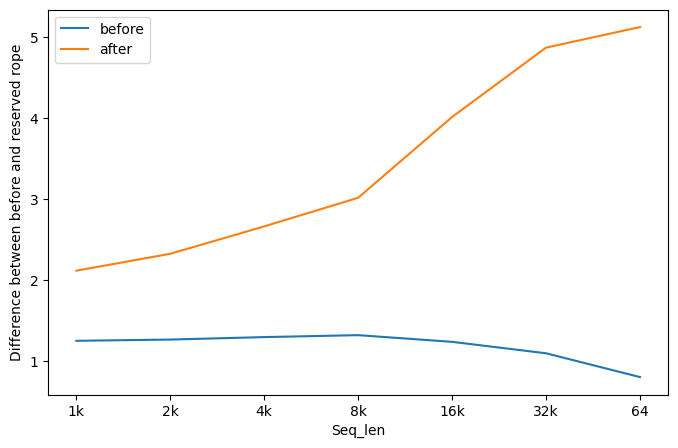

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 5))
x = [1,2,3,4,5,6,7]
# difference = [(270.3109-159.3434), (297.0381-161.3083), (340.3704-165.2157), (385.6309-168.2895),
#               (513.4606-157.7077), (623.1927-139.5949), (655.7042-101.9491)]
after = [270.3109,297.0381,340.3704,385.6309,513.4606,623.1927,655.7042]
before = [159.3434,161.3083,165.2157,168.2895,157.7077,139.5949,101.9491]
after = [x/128 for x in after]
before = [x/128 for x in before]
target_length = ['1k','2k','4k', '8k', '16k', '32k', '64']
# plt.plot(x, difference, label="Difference")
plt.plot(x, before, label="before")
plt.plot(x, after, label="after")
# plt.plot(target_layers, ratio_after_rope_all_layer, label="after rope")
# plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
# plt.xticks(target_length)
plt.xticks(ticks=x, labels=target_length)
plt.xlabel("Seq_len")
plt.ylabel("Difference between before and reserved rope")
# plt.title("Ratio Across Layers with 4k tokens")
plt.legend()
plt.show()

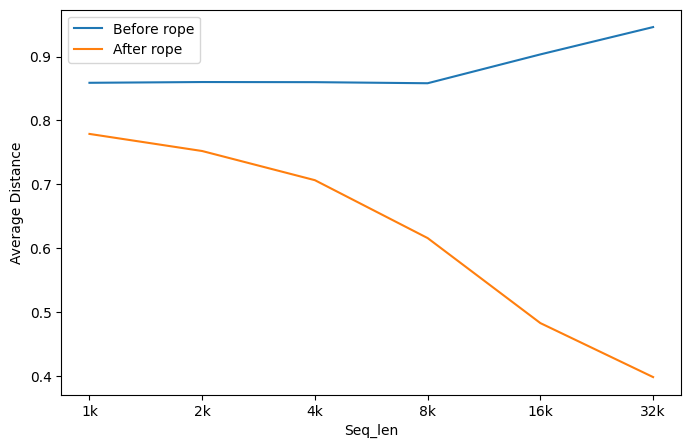

In [1]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 5))
x = [1,2,3,4,5,6]
# difference = [(270.3109-159.3434), (297.0381-161.3083), (340.3704-165.2157), (385.6309-168.2895),
#               (513.4606-157.7077), (623.1927-139.5949), (655.7042-101.9491)]
before = [0.8588, 0.8600, 0.8598, 0.8581, 0.9033, 0.9461]
after = [0.7787, 0.7519, 0.7062, 0.6155, 0.4823, 0.3977]
target_length = ['1k','2k','4k', '8k', '16k', '32k']
plt.plot(x, before, label="Before rope")
plt.plot(x, after, label="After rope")
# plt.plot(target_layers, ratio_after_rope_all_layer, label="after rope")
# plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
# plt.xticks(target_length)
plt.xticks(ticks=x, labels=target_length)
plt.xlabel("Seq_len")
plt.ylabel("Average Distance")
# plt.title("Ratio Across Layers with 4k tokens")
plt.legend()
plt.show()

<Figure size 800x500 with 0 Axes>

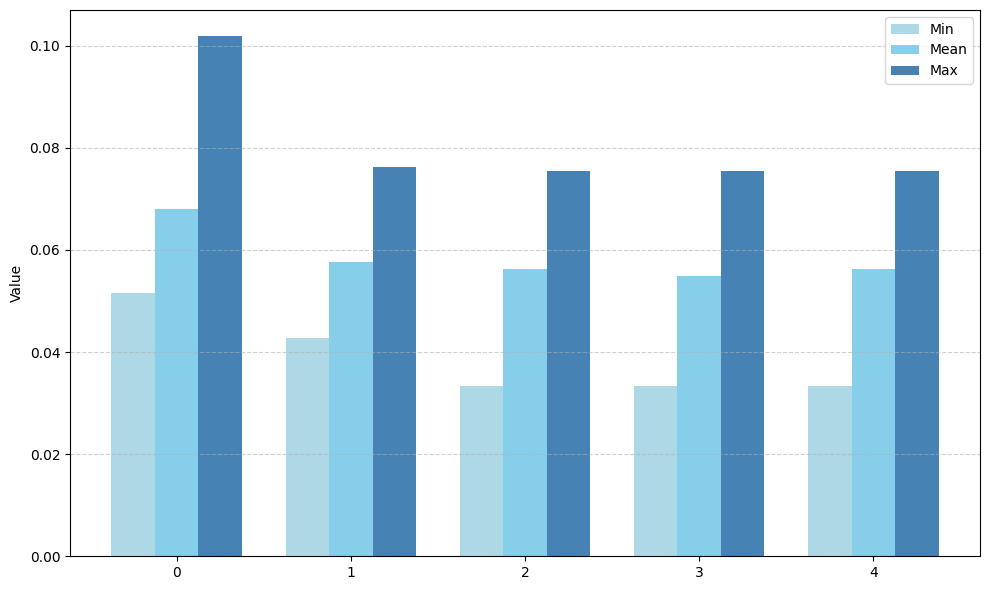

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))
x = [1,2,3,4,5]
mean = [0.067978692,0.057704649,0.056338054,0.054907733,0.056334325]
max = [0.101899501,0.07628255,0.075430742,0.075393954,0.075429192]
min = [0.051662704,0.042715314,0.033328787,0.033296497,0.033329964]
x = np.arange(len(x))  # [0, 1, 2, 3, 4]
bar_width = 0.25  

offsets = [-bar_width, 0, bar_width]


plt.figure(figsize=(10, 6))


plt.bar(x + offsets[0], min, width=bar_width, label='Min', color='lightblue')
plt.bar(x + offsets[1], mean, width=bar_width, label='Mean', color='skyblue')
plt.bar(x + offsets[2], max, width=bar_width, label='Max', color='steelblue')


plt.xticks(x)
# plt.xlabel("Sequence Length")
plt.ylabel("Value")
# plt.title("Token Dispersion Statistics")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()


plt.show()